# Loan Default Report
---
**Author:** Tyler Chang | **Current Version (V.2) Release Date:** November 5, 2023 | [GitHub]('https://github.com/Habeus-Crimpus') | [LinkedIn]('https://www.linkedin.com/in/tylerchang/') | [Data Portfolio]('https://troopl.com/tchang343w')

## Report Summary

Based on the [Coursera loan default prediction challenge](https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction#details) and using data publicly available [here](https://www.kaggle.com/datasets/nikhil1e9/loan-default), the **Loan Default Project** focuses on the development of supervised learning models for predicting whether a given borrower will default on their loan. Using a sample size of over 250K to test multiple model types, a *random forest* model is proposed as the optimal algorithm. With F1 and accuracy scores exceeding 0.93, the model offers a robust means of classifying loans as likely to default or not.

#### Report Contents

This report includes the following sections:

* **Preparing the Data**
  - *Loading the Required Libraries*
  - *Importing the Data*
  - *Cleaning the Data*
  - *Encoding the Data*
* **Exploring the Data**
  - *Distribution of Borrowers' Ages*
  - *Income and Loan Value Relationship*
  - *Credit Score and Loan Value Relationship*
  - *Correlation Heatmap for Features*
* **Modeling the Data**
  - *Creating the Feature and Target Sets*
  - *Unadjusted Models*
  - *Adjusting the Data*
  - *Adjusted Models*
  - *Optimizing the XGBoost and Random Forest Models*
  - *Comparing the XGBoost and Random Forest Models' Accuracies*
  - *Creating the Final Models*
    - XGBoost
    - Random Forest
    - Results Table
  - *Feature Importance*
    - XGBoost
    - Random Forest
* **Conclusions**
  - *Findings*
  - *Ethical Concerns*
* **Final Notes**
  - *Future Work*
  - *Credits and Disclaimers*

<a name="header-2"></a>
## Preparing the Data

### Loading the Required Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# machine learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, make_scorer
from xgboost import XGBClassifier   # I am loading this separately to make the code later shorter
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# miscellaneous
from IPython import display
#from pandasql import sqldf  # this is included from an earlier version. The SQL has been removed for optimization reasons.
import joblib   # this is useful if you want to save a model


### Importing the Dataset

In [2]:
df = pd.read_csv('Loan_default.csv')
df.head()


LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes           Yes       Other   
1      Full-time       Married          No            No       Other   
2     Unemployed      Divorced         Yes           Yes        Auto   
3      Full-time       Married          No            No    Business   
4     Unemployed      Divorced          No           Yes        Auto   

  HasCoSigner  Default  
0         Yes        0  
1         Yes        0  
2          No        1  
3          No        0  
4          No        0

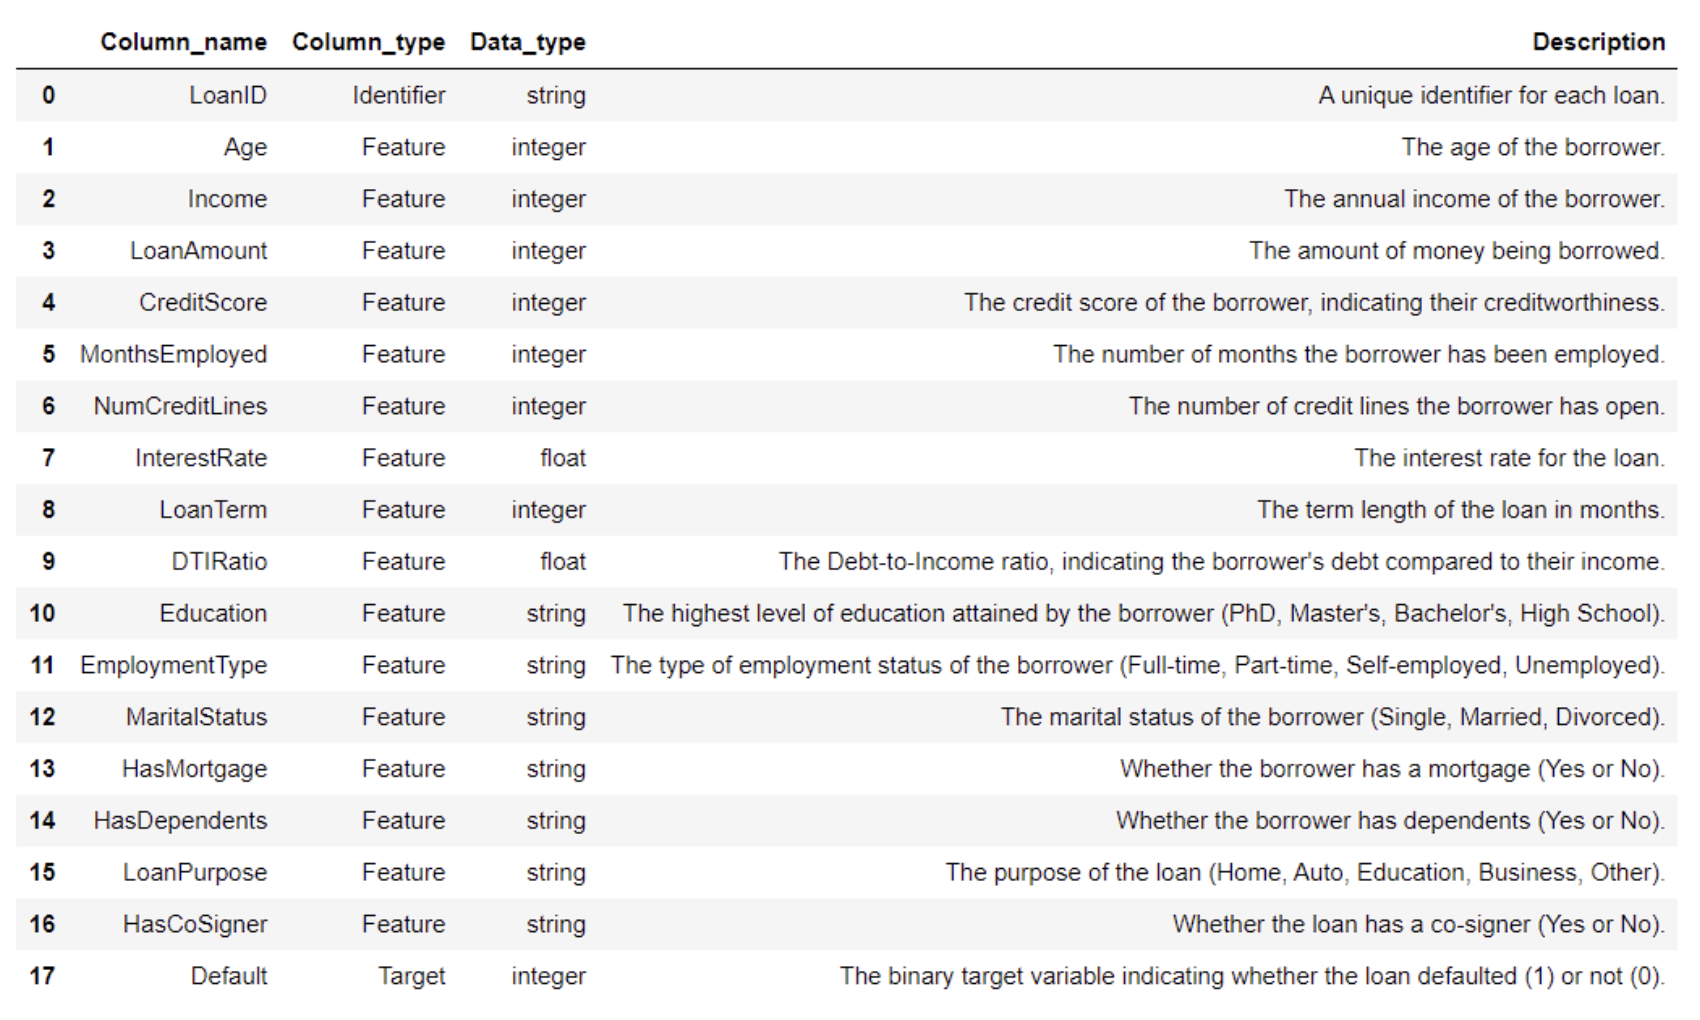

In [3]:
### showing the description for the table's content
display.Image('Column_Descriptions.png')


The **Default** column is the target. It contains only two possible values, 1 and 0, representing that a loan defaulted and that it did not, respectively. Nearly all of the other columns are potential features, with the one exception being *LoanID*, as each value is unique and will offer no information.

*Note:* By design, all of the loans are taken by a single borrower and no borrower has multiple loans. If this were not the case, then the loanID could indicate a impactful pattern about the borrower's behaviors.

### Cleaning the Data

The first step, however, is to make sure that the data is in a usable state. This includes checking for missing values and ensuring that all values make sense (e.g., no negative values for age). 

In [4]:
### checking the non-null counts for columns against the number of rows in the table
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

There are 255,347 rows and all of the columns have 255,347 non-null values, meaning there are no missing values.

This does not mean that all the values are valid. None of the numeric columns should have any negative values and all of the text-based columns (indicated by the tag "object" in the table above) must include only the anticipated values as outlined in the earlier image.

In [5]:
### confirming that there are no negative values in the numeric columns
df.describe()


Age         Income     LoanAmount    CreditScore  \
count  255347.000000  255347.000000  255347.000000  255347.000000   
mean       43.498306   82499.304597  127578.865512     574.264346   
std        14.990258   38963.013729   70840.706142     158.903867   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48825.500000   66156.000000     437.000000   
50%        43.000000   82466.000000  127556.000000     574.000000   
75%        56.000000  116219.000000  188985.000000     712.000000   
max        69.000000  149999.000000  249999.000000     849.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   255347.000000   255347.000000  255347.000000  255347.000000   
mean        59.541976        2.501036      13.492773      36.025894   
std         34.643376        1.117018       6.636443      16.969330   
min          0.000000        1.000000       2.000000      12.000000   
25%         30.000000        2.000000       7.770000      24.000000   
50%         60.000000        2.000000      13.460000      36.000000   
75%         90.000000        3.000000      19.250000      48.000000   
max        119.000000        4.000000      25.000000      60.000000   

            DTIRatio        Default  
count  255347.000000  255347.000000  
mean        0.500212       0.116128  
std         0.230917       0.320379  
min         0.100000       0.000000  
25%         0.300000       0.000000  
50%         0.500000       0.000000  
75%         0.700000       0.000000  
max         0.900000       1.000000

As expected, none of the columns contain a negative value. It is also evident from the Default column that the vast majoprity of loans do not default (more on that later). The text-based columns must now also be checked for reasonable elements.

In [6]:
### education column
df.Education.value_counts()


Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64

In [7]:
### employment type column
df.EmploymentType.value_counts()


EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64

In [8]:
### marital status
df.MaritalStatus.value_counts()


MaritalStatus
Married     85302
Divorced    85033
Single      85012
Name: count, dtype: int64

In [9]:
### mortgage status
df.HasMortgage.value_counts()


HasMortgage
Yes    127677
No     127670
Name: count, dtype: int64

In [10]:
### dependents status
df.HasDependents.value_counts()


HasDependents
Yes    127742
No     127605
Name: count, dtype: int64

In [11]:
### loan purpose
df.LoanPurpose.value_counts()


LoanPurpose
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: count, dtype: int64

In [12]:
### co-signer status
df.HasCoSigner.value_counts()


HasCoSigner
Yes    127701
No     127646
Name: count, dtype: int64

There are no unexpected values in the text-based columns. As will be important during the modeling process, the distribution of the unique elements of these columns are also nearly perfectly balanced. This removes the issue of over or under representing a particular category in a given feature later on.

### Encoding the Data

Since several of the columns are non-numeric, they will need to be encoded numerically before they can be used to make models. This will be achieved via a mix of **one-hot encoding** and **label encoding**.

**Label Encoding**
* Education
* EmploymentType
* MaritalStatus
* LoanPurpose

**One-hot Encoding**
* HasMortgage
* HasDependents
* HasCoSigner

In [13]:
# label encoding
label_encoder = LabelEncoder()
df['Education_encoded'] = label_encoder.fit_transform(df['Education'])
df['EmploymentType_encoded'] = label_encoder.fit_transform(df['EmploymentType'])
df['MartialStatus_encoded'] = label_encoder.fit_transform(df['MaritalStatus'])
df['LoanPurpose_encoded'] = label_encoder.fit_transform(df['LoanPurpose'])

# one-hot encoding
df = pd.get_dummies(df, columns = ['HasMortgage', 'HasDependents', 'HasCoSigner'])

# making the one-hot encoded columns numeric
df['HasDependents_No'] = df.HasDependents_No.astype(int)
df['HasDependents_Yes'] = df.HasDependents_Yes.astype(int)
df['HasCoSigner_No'] = df.HasCoSigner_No.astype(int)
df['HasCoSigner_Yes'] = df.HasCoSigner_No.astype(int)
df['HasMortgage_No'] = df.HasMortgage_No.astype(int)
df['HasMortgage_Yes'] = df.HasMortgage_No.astype(int)

# dropping unneeded columns
df.drop(columns=['LoanID', 'LoanPurpose', 'Education',
                               'EmploymentType',  'MaritalStatus'],
                inplace=True)

# changing all datatypes to float64 (this was done to fix an error)
#df = df.astype(float)


That completes the prepatory steps for the data. During the modeling section, I will rescale the data and rebalance the classes, but for now, this is sufficient to start exploring the data.

<a name="heading-2"></a>
## Exploring the Data

### Distribution of Borrowers' Ages

We see from an earlier table that the average age of a loan taker is 43 years old with the dataset including borrowers ranging from 18 to 69 years old. This age range is to be expected since most loan providers do not offer loans to minors and many seniors have already acquired the sorts of items (homes, education, cars, etc.) for which loans are most often taken. Notably, no loans that were taken for medical expenses are included in this dataset. Were they included, I suspect that the upper limit on the ages would rise. 

It is still important to check that we do not have an imbalance in the ages represented by the data. To check this, we can plot the distribution of the frequency of the ages.

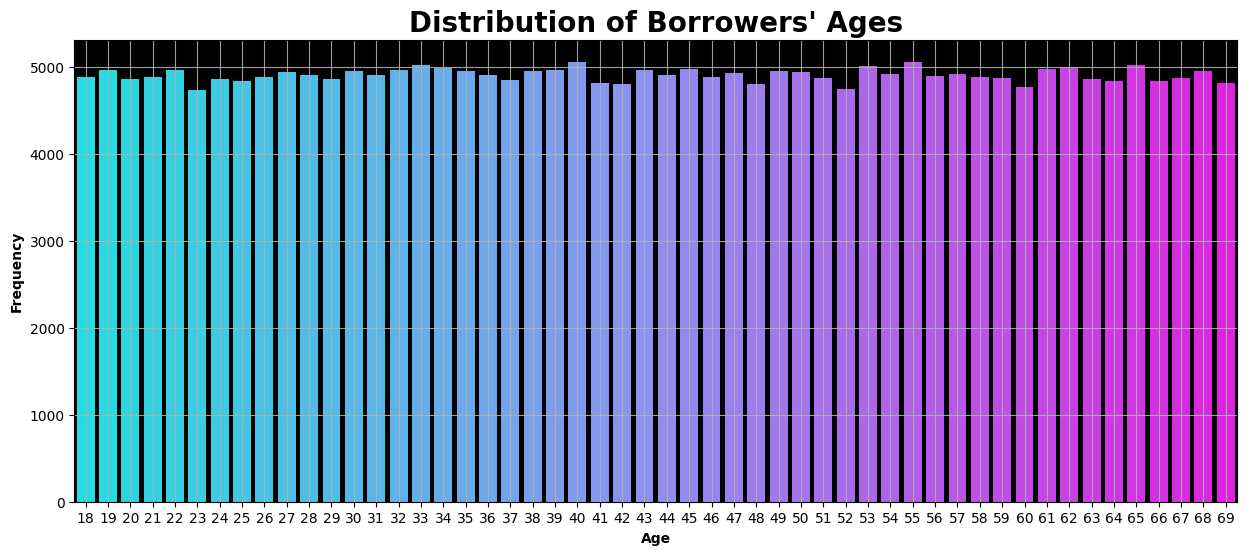

In [14]:
# counting the number of loan-taker for each age + sorting by age (ascending)
age_counts = pd.DataFrame(df.Age.value_counts().sort_index()).reset_index()
age_counts.columns = ['Age', 'Count']

# making the chart
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Age', y = 'Count', data = age_counts, palette = 'cool')
plt.xlabel('Age', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title("Distribution of Borrowers' Ages", weight = 'bold', size = 20)
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()


There are similar numbers of persons included in the dataset for each age. This was shown numerically earlier but is presented visually here.

### Income and Loan Value Relationship

It is also important to get a better view of the incomes and loan values of the borrowers. Since a person's income is a key element to their paying back a loan, understanding the relationship between the two is crucial.

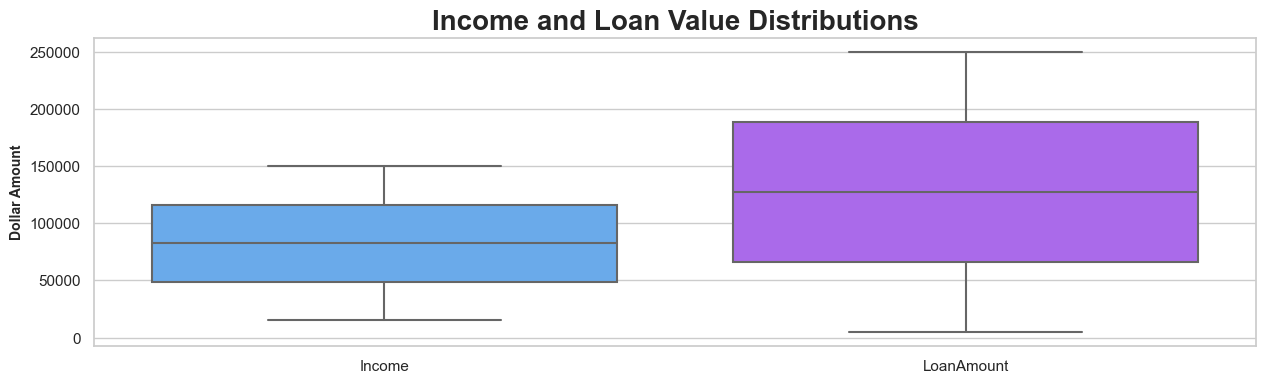

In [15]:
plt.figure(figsize=(15, 4))
sns.set(style = 'whitegrid')
sns.boxplot(df[['Income', 'LoanAmount']], palette='cool')
plt.ylabel('Dollar Amount', weight = 'bold', size = 10)
plt.title('Income and Loan Value Distributions', weight = 'bold', size = 20)
plt.show()


There are no outlier values for either income or loan amount. This alone does not allow us to say too much about the overall dataset by itself but it does allow us to continue without worrying about an unusually large value skewing later results.

The incomes range from 15k to approximately 150k and the loan amounts range from 5k up to 249k. The majority of loan takers
had an income under 116k, which is lower than the average loan of 127.5k. This shows that the average loan is substantially larger than the average income but to better understand the relationship between the two measurements, we have to look at the difference between income and loan amount by loan taker.

In [16]:
# Calculating the net differnece between income and loan amount AND
# the percentage of a person's income that the loan represents.
'''
Note: The incLoanPerDiff (income loan percentage difference) is in terms of percent, meaning
that a value of 246.7 means that the loan is 246.7% of the loan takers income.

The incLoanNetDiff is measuring the raw difference between a person's income and the loan
value. If the list value is positive, the person took a loan that is smaller than their
income and if the value is negative, the loan is larger than the income.
'''
incLoanNetDiff = []
incLoanPerDiff = []
for i in range(df.shape[0]):
    incLoanNetDiff.append(df.Income[i] - df.LoanAmount[i])
    incLoanPerDiff.append((df.LoanAmount[i] / df.Income[i])*100)

# adding the new lists to the table
df['IncLoanNetDiff'] = incLoanNetDiff
df['IncLoanPerDiff'] = incLoanPerDiff

# displaying the numeric summary of the two new columns
df[['IncLoanNetDiff', 'IncLoanPerDiff']].describe()


IncLoanNetDiff  IncLoanPerDiff
count   255347.000000   255347.000000
mean    -45079.560915      217.747982
std      80878.297292      217.835733
min    -234492.000000        3.374929
25%    -106751.000000       80.362790
50%     -44996.000000      154.672013
75%      16325.500000      267.174408
max     144721.000000     1653.245976

The average loan is approximately 45,079 greater than the borrower's income and the loans total value represents approximatley 217.7% of their income. This is somewhat differently represented by the median loan-income difference
at 44,996 and the median percentage of income represented at approximately 154.7%. This implies that those taking 
loans larger than the median value are larger by a greater magnitude than those who take smaller loans are smaller. 

This is shown by the following two charts:

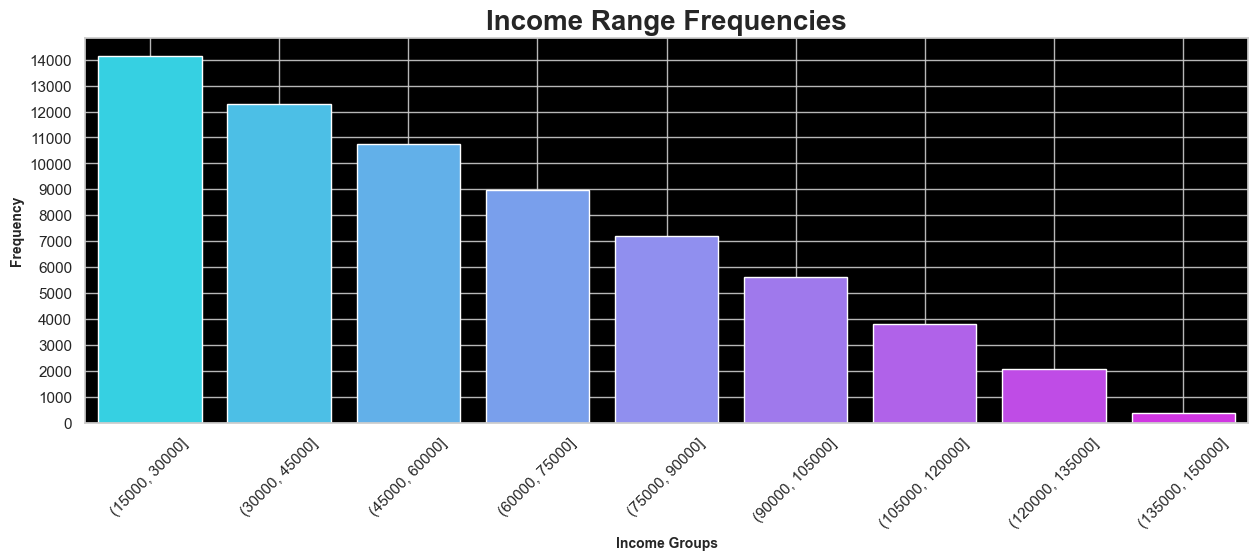

In [17]:
# defining bin edges for the IncLoanNetDiff column
diff_bin_edges = range(15000, 160000, 15000)

# making bins
df['IncLoanDiff_bins'] = pd.cut(df['IncLoanNetDiff'], bins = diff_bin_edges)

# Counting the frequency in each bin
income_counts = df.IncLoanDiff_bins.value_counts().reset_index()
income_counts.columns = ['Income Value', 'Count']

# plotting the IncLoanNetDiff frequency counts
plt.figure(figsize = (15, 5))
sns.set(style = 'whitegrid')
ax = sns.barplot(x = 'Income Value', y = 'Count', data = income_counts, palette = 'cool')
plt.xlabel('Income Groups', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title('Income Range Frequencies', weight = 'bold', size =20)
plt.xticks(rotation = 45)
plt.yticks(list(range(0, 15000, 1000)))
ax.set_facecolor('black')
#for spine in ax.spines.values():
#    spine.set_visible(False)
plt.grid(alpha = 0.9)
plt.show()


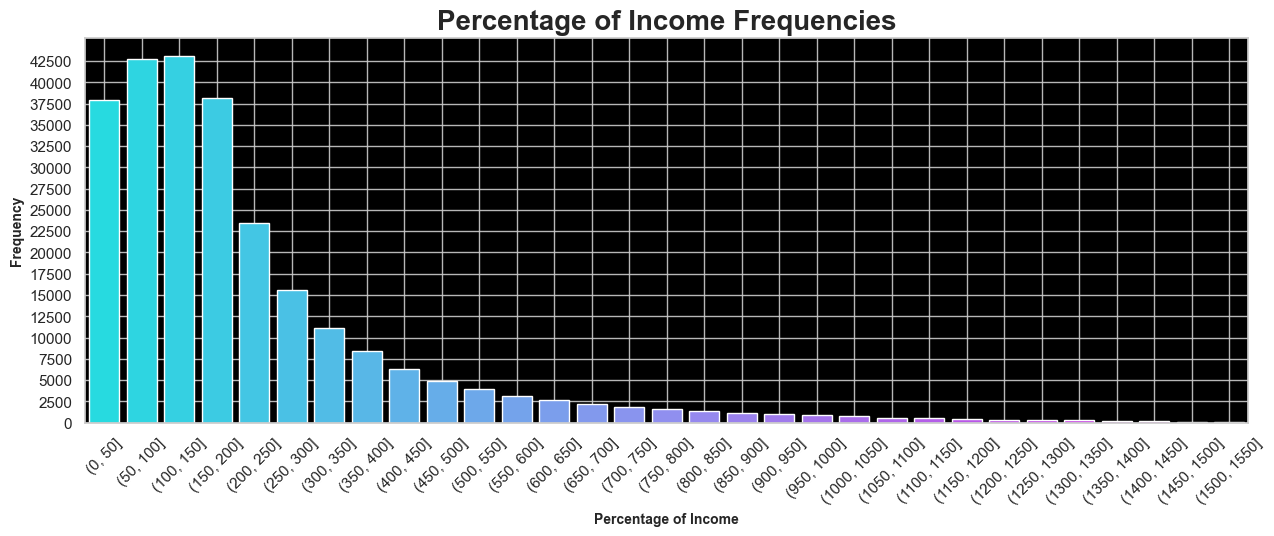

In [18]:
# defining bin edges for the IncLoanPerDiff column
per_bin_edges = range(0, 1600, 50)

# making bins
df['IncLoanPer_bins'] = pd.cut(df['IncLoanPerDiff'], bins = per_bin_edges)

# Counting the frequency in each bin
per_counts = df.IncLoanPer_bins.value_counts().reset_index()
per_counts.columns = ['Percentage Value', 'Count']

# plotting the IncLoanNetDiff frequency counts
plt.figure(figsize = (15, 5))
sns.set(style = 'whitegrid')
ax = sns.barplot(x = 'Percentage Value', y = 'Count', data = per_counts, palette = 'cool')
plt.xlabel('Percentage of Income', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title('Percentage of Income Frequencies', weight = 'bold', size =20)
plt.xticks(rotation = 45)
plt.yticks(list(range(0, 45000, 2500)))
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()


The **Income Range Frequecies** chart is very positively skewed with a consistently declining frequency as you go up in 
income group. This is somewhat expected since the most common reasons for taking loans--education, housing, healthcare, cars--become less prohibitively expensive without loan assistance as your income goes up. 

The **Percentage of Income Frequencies** chart is also positively skewed with the largest groups being those borrowing between
50-100% and 100-150% of their income's value. There is a significant drop-off in loan takers after the percentage of income being borrowed exceeds 350% and this downward trend continues consistently for the rest of the percentage ranges. 

We can improve our understanding of the relationship between income and loan amount by plotting the relationship directly:

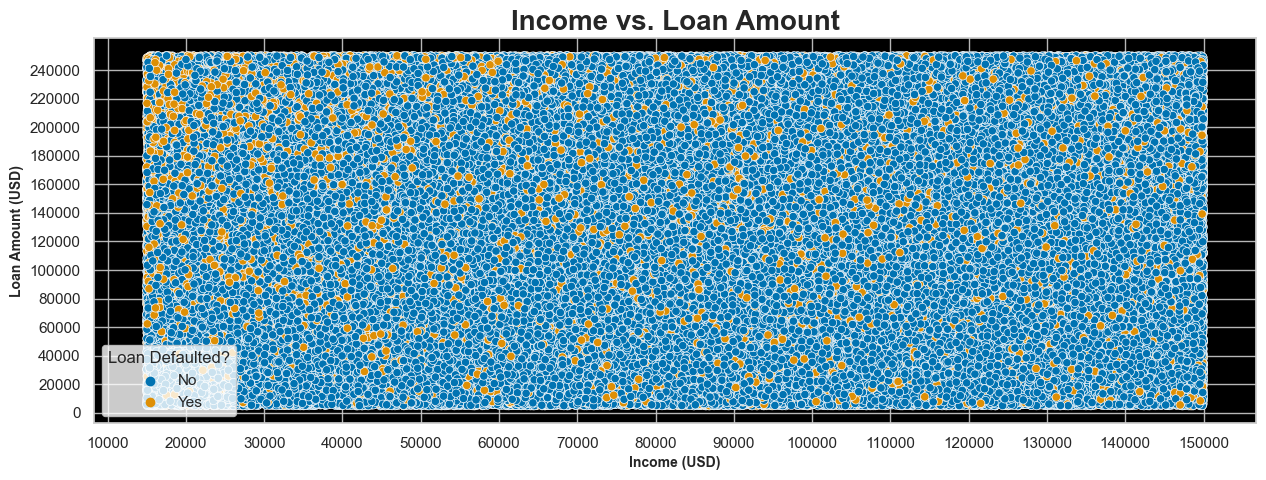

In [19]:
# adding a column to the table for coloring purposes
df['Default_word_ver'] = ['Yes' if val == 1 else 'No' for val in df.Default]

# plotting the incomes against their associated loan amounts
plt.figure(figsize = (15, 5))
ax = sns.scatterplot(data = df, x = 'Income', y = 'LoanAmount', hue = 'Default_word_ver', palette='colorblind')
plt.legend(loc = 'lower left', title = 'Loan Defaulted?')
plt.xlabel('Income (USD)', weight = 'bold', size = 10)
plt.ylabel('Loan Amount (USD)', weight = 'bold', size = 10)
plt.title('Income vs. Loan Amount', weight = 'bold', size = 20)
plt.yticks(list(range(0,260000,20000)))
plt.xticks(list(range(10000,160000,10000)))
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()


From this chart, we can see a few key findings:
* The vast majority of loans do not default.
* There is no apparent correlation between income level and loan amount. 
* There are more loans that default on the lower end of incomes but there are defaulting loans throughout the entire range.

To make the default-to-no-default ratio more precise, consider the following pie chart.

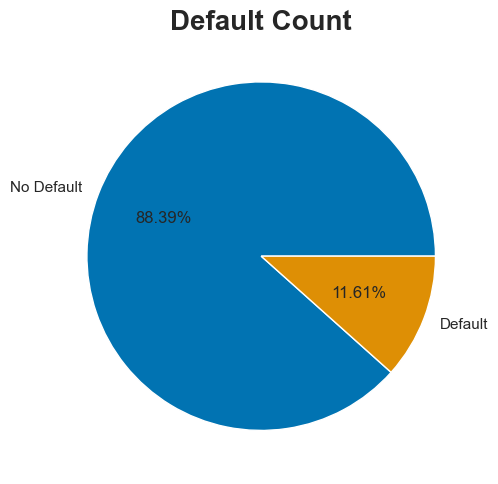

In [20]:
# counting the number of defaults/no defaults and the percentages they make up.
default_df = pd.DataFrame({'Category': ['No Default', 'Default'],
                           'Count': [df[df['Default']==0].count()['Default'],
                                     df[df['Default']==1].count()['Default']]})

# creating the data for the charts
count_data = [val for val in default_df.Count]

# making the pie chart
labels = ['No Default', 'Default']
palette_color = sns.color_palette('colorblind')
plt.figure(figsize=(15, 5))
plt.pie(count_data, labels = labels, colors = palette_color, autopct = '%1.2f%%')
plt.title('Default Count', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()


In [21]:
# Displaying the actual number in each of the above categories
default_df


Category   Count
0  No Default  225694
1     Default   29653

There are 225,694 loans that did not default, accounting for approximately 88.39% of the borrowers, and 29,653 loans that
did default, making up the remaining 11.61%. So, while there are a large number of defaulting loans, they are far from being
the majority. As will be shown later, this imbalance in classes does have a significant effect on model performance and will 
be adjusted for later on.


### Credit Score and Loan Value Relationships

Now, while income does affect the size of a loan that is accessible to a person, their credit score also tends to affect their eligibility. To examine the effect this has on the loans, let's first look at the how many people have a given credit score.

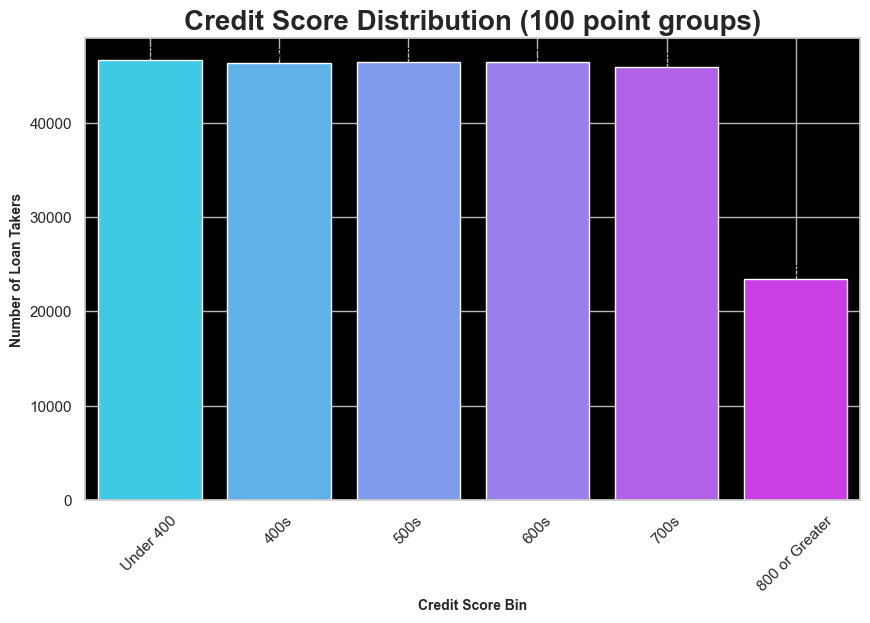

In [22]:
'''
I have chosen to make buckets out the credit scores since the results with the raw data are largely unreadable. The
buckets are grouped by hundreds.
'''
# selecting only the credit score column
cred_scores = df.CreditScore
# Making the bins
cred_score_bins = []
for score in cred_scores:
    if score < 400:
        cred_score_bins.append('Under 400')
    elif score >= 400 and score < 500:
        cred_score_bins.append('400s')
    elif score >= 500 and score < 600:
        cred_score_bins.append('500s')
    elif score >= 600 and score < 700:
        cred_score_bins.append('600s')
    elif score >= 700 and score < 800:
        cred_score_bins.append('700s')
    else:
        cred_score_bins.append('800 or Greater')
# making the list of bins into a series
cred_score_bins = pd.Series(cred_score_bins)
# counting the counts for each bin
bin_counts = cred_score_bins.value_counts().reset_index()
reorder_dir = [0,3,1,2,4,5] # manually adjusting the order of the rows
bin_counts = bin_counts.iloc[reorder_dir]   # reordering the rows of the table
# making the bar chart
plt.figure(figsize=(10,6))
ax = sns.barplot(x = 'index', y = 'count', data = bin_counts, palette='cool')
plt.title('Credit Score Distribution (100 point groups)', weight = 'bold', size = 20)
plt.xlabel('Credit Score Bin', weight = 'bold', size = 10)
plt.ylabel('Number of Loan Takers', weight = 'bold', size = 10)
plt.xticks(rotation = 45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2.,\
        p.get_height()), ha='center', va='center', fontsize=10, color='black',\
            xytext=(0, 5), textcoords='offset points')
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()


In [23]:
# highest and lowest credit scores
df.CreditScore.max(), df.CreditScore.min()


(849, 300)

With the exception of those with a credit score of 800 or greater, there are very similar numbers of borrowers in each of the
credit score categories. The highest credit score in the dataset is 849, which helps to explain why there are fewer people in the 800+ credit score group. The lowest credit score being 300 makes the range of possible values for the under 400 category the same as all others besides 800 or greater, which might explain why we see similar frequency in the lowest category as we do with the middle ones.

We can now examine the relationship between loan amount and credit score via a scatteplot.

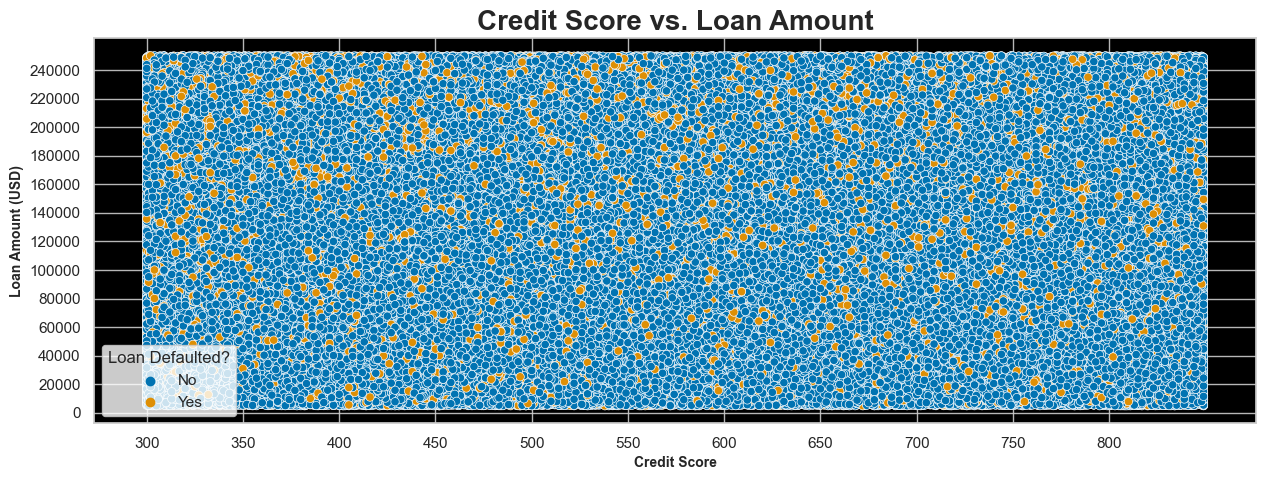

In [24]:
# plotting the credit scores against their associated loan amounts
plt.figure(figsize = (15, 5))
ax = sns.scatterplot(data = df, x = 'CreditScore', y = 'LoanAmount', hue = 'Default_word_ver', palette='colorblind')
plt.legend(loc = 'lower left', title = 'Loan Defaulted?')
plt.xlabel('Credit Score', weight = 'bold', size = 10)
plt.ylabel('Loan Amount (USD)', weight = 'bold', size = 10)
plt.title('Credit Score vs. Loan Amount', weight = 'bold', size = 20)
plt.yticks(list(range(0,260000,20000)))
plt.xticks(list(range(300,850,50)))
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()


There appears to be even less correlation between credit score and loan amount, as well as little relationship as to
whether a loan defaulted. This suggests that neither income level, credit score, nor size of the loan independently serve as 
good predictors of whether a loan defaults. To predict loan defaults accurately seems to require a combination of multiple factors. 


### Correlation Heatmap for Features

We can check the correlation between all of the numeric features using a heatmap. 

In [25]:
### dropping two columns that were made for previous plots
df.drop(columns = ['IncLoanDiff_bins', 'IncLoanPer_bins',
                   'Default_word_ver'], inplace = True)


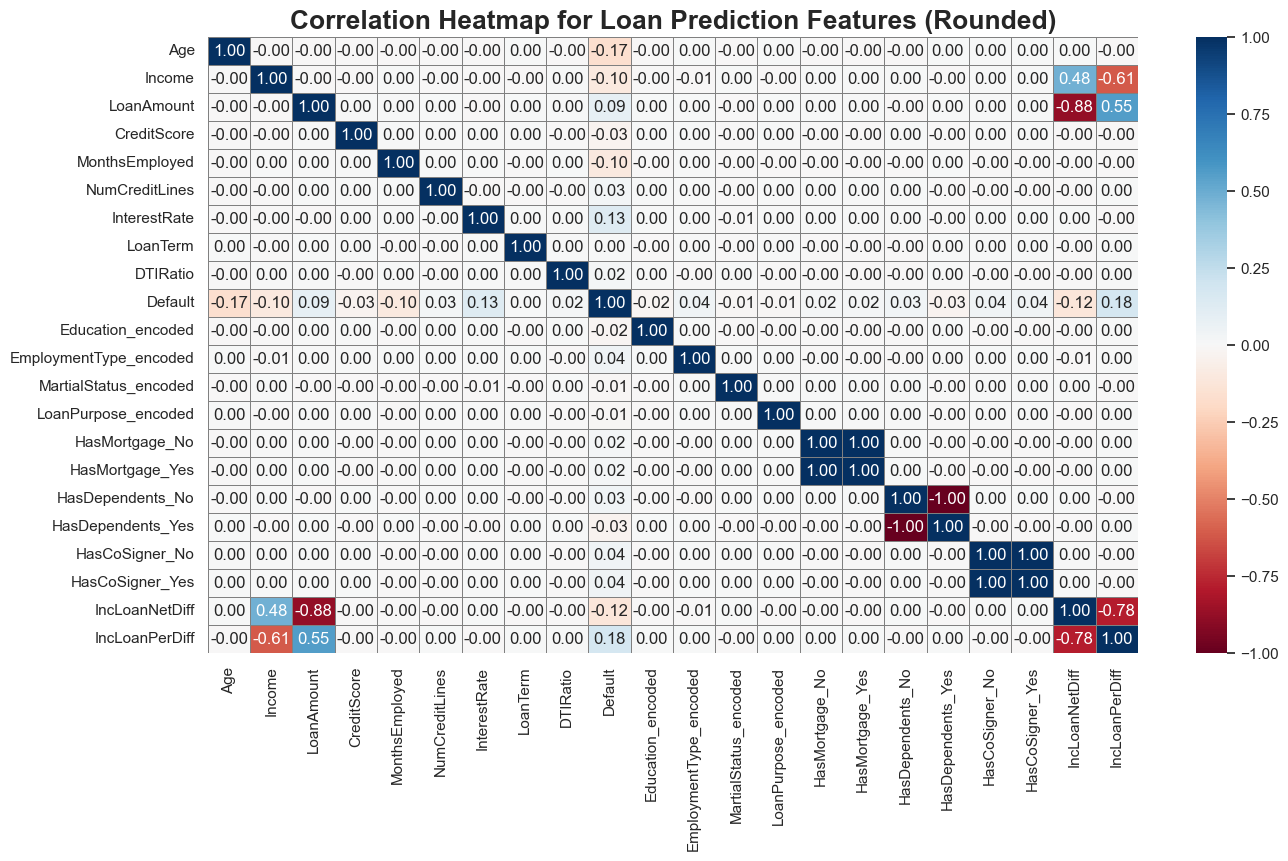

In [28]:
### making the heatmap
plt.figure(figsize = (15, 8))
sns.heatmap(data = df.corr(),
            linewidths = 0.5, linecolor = 'grey',
            annot = True, fmt = '.2f',
            cmap = 'RdBu')
plt.title('Correlation Heatmap for Loan Prediction Features (Rounded)', weight = 'bold', size = 19)
plt.show()


The overwhelming majority of feature pairs are uncorrelated. Among the pairings that are somewhat correlated, the strongest correlations (besides those paired with themselves) appear between those of the form "category_yes" and "category_no", e.g., HasMortage_Yes and HasMortgage_No. This should not, however, be taken as a significant indication of how two separate features will impact a model. Since these pairs of features are effectively repeated information presented with opposing language (i.e., once you know if someone said yes to having a mortgage, you also know whether they said no to having a mortgage), they will necessarily be perfectly negatively correlated. This also implies that it is likely that one of the two features in each pairing could be dropped without losing any information during the modeling process. 

A similar but nontrivially different situation is occuring with the correlations of *IncLoanNetDiff* and *IncLoanPerDiff*. They are fairly strongly negatively correlated with one another but not perfectly (approximately -0.78). This suggests that all the raw difference in income vs. loan value increases, the percentage of said income that the loan represents typically decreases (and vice versa). To explain this, we can also look at the following correlation pairings:

* *IncLoanNetDiff & Income*: 0.48
* *IncLoanNetDiff & LoanAmount*: -0.88
* *IncLoanPerDiff & Income*: -0.61
* *IncLoanPerDiff & LoanAmount*: 0.55

The first two pairs imply that as a borrower's income increases, the net difference between their income and the loan's value also increases. It is also implied that as the loan amount increases, the net diffference will lessen. Importantly, *IncLoanNetDiff* can be negative since it was obtained by subtracting the loan amount from the income. Together, this suggests that as a person's income rises, they are more likely to borrow a greater amount and that larger loans are typically representative of smaller differences between the amount being borrowed and the borrower's income. 

An apparently opposite relationship is observed with the pairs involving *IncLoanPerDiff*. Now, *Income* is negatively correlated and *LoanAmount* is positively correlated with *IncLoanPerDiff*. Despite this inversion, it implies similar findings to the first two pairings. As the income rises, the percentage of the income that the loan represents shrinks. This is an effect akin to that which was observed in the second pair. Similarly, the fourth pair is representing information much like the first pair. 

There are non-zero correlation values for each feature that is paired with *Default*, which suggests that all of the features will have some effect on an eventual model. That said, most are very weakly correlated, reaching values no greater than +-0.04. The following pairs do exceed that threshold:

* *Default & Age*: -0.17
* *Default & Income*: -0.10
* *Default & LoanAmount*: 0.09
* *Default & MonthsEmployed*: -0.10
* *Default & Interest Rate*: 0.13
* *Default & IncLoanNetDiff*: -0.12
* *Default & IncLoanPerDiff*: 0.18

These correlation values suggest that a higher age, income, number of months the borrower has been employed, and the net difference between the income and the loan's value all lower the likelihood of the loan defaulting. Similarly, the higher the loan amount, interest rate, and the percentage of the income that the loan represents, the greater likelihood that the loan will default. Still, none of these correlations are especially strong, meaning that it is unlikely that any single (or even a handful) of the features will deliver a well-performing prediction by itself. 

<a name="header-2"></a>
## Modeling the Data

The models tested here include:

* Logistic Regression
* Decision Trees
* Random Forest
* Naive Bayes
* XGBoost

I have chosen these models in order to include mixture of different modeling styles. It is not an exhaustive list. Some of the notable exceptions include K-Nearest Neighbors, SVM, and Deep Learning methods, but the performance of the final models are 
sufficiently powerful to make further model testing presently unneeded. 

Since 88.39% of the loans did not default, we have a **baseline accuracy** of 0.8839. As will be discussed in the concluding sections, accuracy is not necessarily the most important metrics here. From a consumer point-of-view, having high precision is likely also important since it would minimize the number of people who are rejected for a loan because the model falsely predicts that they would default on the loan. Similarly, a business may be more concerned with recall because a high false negative rate would result in a greater number of loans being given to people who are more likely to default. 

As I will elaborate on later, the **F1 score** offers the best measurement of a model's performance since they represent a more balanced level of concern with both precision and recall. That said, the final models--**XGBoost** and **Random Forest**--both yield high values across all metrics.

### Creating the Feature and Target Sets

In [29]:
# making the feature table and the prediction column
X = df.drop(columns = ['Default'])
y = df.Default


### Unadjusted Models

At this point, the data has not been adjusted to account for the imbalance in the target classes nor have the features been scaled to a uniform range. This unadjusted data will be used first to determine a base level performance for the models, though these first models will barely outperform the baseline accuracy of 88.39%. 

I am also splitting the data twice. The first split is to create an initial training set and a testing set. To be able to evaluate the models while preserving a portion of the data for final testing, I will split this initial training set into a new training set and a validation set.

In [30]:
# making a table to track the performance of the models
metrics = {'Model': [],
           'Accuracy': [],
           'Precision': [],
           'Recall': [],
           'F1-Score': [],
           'ROC_AUC': []}


In [31]:
# splitting the datasets into train-validation-testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)

# setting up the models
models = {
    "Logistic Regression": LogisticRegression(max_iter = 10000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state = 8413),
    "Random Forest": RandomForestClassifier(random_state = 8413),
    "XGBoost": XGBClassifier(random_state = 8413)
}

# cross-validating the models
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
    precisions = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'precision')
    recalls = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'f1')
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc')

    # Adding results to the metrics dictionary
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(np.mean(accuracies))
    metrics['Precision'].append(np.mean(precisions))
    metrics['Recall'].append(np.mean(recalls))
    metrics['F1-Score'].append(np.mean(f1_scores))
    metrics['ROC_AUC'].append(np.mean(roc_auc_scores))


In [32]:
# Making the metrics dictionary into a dataframe and displaying the table
model_base_scores_df = pd.DataFrame(metrics)
model_base_scores_df


Model  Accuracy  Precision    Recall  F1-Score   ROC_AUC
0  Logistic Regression  0.885559   0.595862  0.050640  0.093169  0.734859
1          Naive Bayes  0.859577   0.327618  0.197768  0.246631  0.714906
2        Decision Tree  0.802767   0.200520  0.233195  0.215626  0.555441
3        Random Forest  0.885590   0.599565  0.047955  0.088791  0.727170
4              XGBoost  0.883773   0.500337  0.085961  0.146707  0.733173

Given a baseline accuracy of 0.8839, the models based on the unadjusted data all either fall short of the baseline or are less than 1% better. This is made worse when other metrics are considered, with all models having very low precision, recall, f1, and ROC-AUC scores. 

### Adjusting the Data

To adjust the data, I will use the *standard scaler* from *sklearn* to handle any bias originating from the varying scales of the features. Since over 88% of the data was labeled as not defaulting, there may overrepresentation of loans that did not default in the modelling process. To deal with this, I will apply SMOTE to manage the class imbalance in the target set. Once these adjustments are made, the train, validation, and test sets must be recreated.

In [33]:
# rescaling the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# rebalancing the classes
smote = SMOTE(random_state=8413)
X_rebal, y_rebal = smote.fit_resample(X_scale, y)

# resplitting the data
X_train, X_test, y_train, y_test = train_test_split(X_rebal, y_rebal, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)


### Adjusted Models

With the data scaled and rebalanced, the models can be remade. As before, I will rely on a 3-fold cross validation method to determine the scores. My choice to use 3 folds is primarily based on personal computational limitations and should not be taken as a restriction on the actual modeling options (provided different computing options, I would have likely tried 5 or 10 folds).

In [34]:
### Making a dictionary to track all of the model scores
metrics_2 = {"Model": [],
          "Accuracy": [],
          "Precision": [],
          "Recall": [],
          "F1-Score": [],
          "ROC_AUC": []}

# remaking the models with scaled and balanced dataset
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
    precisions = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'precision')
    recalls = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'f1')
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc')

    # Adding results to the metrics dictionary
    metrics_2['Model'].append(model_name)
    metrics_2['Accuracy'].append(np.mean(accuracies))
    metrics_2['Precision'].append(np.mean(precisions))
    metrics_2['Recall'].append(np.mean(recalls))
    metrics_2['F1-Score'].append(np.mean(f1_scores))
    metrics_2['ROC_AUC'].append(np.mean(roc_auc_scores))


In [35]:
### Changing the metrics dictionary into a dataframe for viewing
model_2_scores_df = pd.DataFrame(metrics_2)
model_2_scores_df


Model  Accuracy  Precision    Recall  F1-Score   ROC_AUC
0  Logistic Regression  0.697786   0.696302  0.702265  0.699270  0.766893
1          Naive Bayes  0.672032   0.709873  0.582601  0.639970  0.748045
2        Decision Tree  0.825316   0.817414  0.838070  0.827610  0.825308
3        Random Forest  0.921714   0.940940  0.900026  0.920027  0.974179
4              XGBoost  0.929284   0.986836  0.870269  0.924894  0.964833

We now see a significant rise in performance for precision, recall, F1, and ROC_AUC. While accuracy has decreased for the first three models--logistic regression, naive bayes, and decision tree--the last two--**random forest** and **XGBoost**--have seen their accuracies rise by approximately 3.4%. As such, I will now further tune the latter two to find the best performing model.


### Optimizing the XGBoost and Random Forest Models

I will use a grid search to determine the best hyperparameters for each model. I will also optimize for f1 score since it provides the best balance between precision and recall, both of which are more important than raw accuracy here.

In [36]:
# Making a dictionary to track the tuned model performances
tuned_model_dict = {
    'Model Type': [],
    'Metric': [],
    'Score': []
}


**XGBoost**

In [37]:
### Making the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

### Re-instantiating the model
xgb_tuned_model = XGBClassifier(objective='binary:logistic',
                          random_state = 8413)

### creating scoring function for f1 score
f1_scorer = make_scorer(f1_score, average = 'micro') #micro since this is a binary task

### Performing the grid search
xgb_grid_search = GridSearchCV(
    xgb_tuned_model,
    param_grid,
    cv = 5,
    scoring = f1_scorer,
    verbose = 1
)

### fitting the model
xgb_grid_search.fit(X_train, y_train)

### Checking the results of the grid search
best_tuned_xgb_model = xgb_grid_search.best_estimator_
best_xgb_f1_params = xgb_grid_search.best_params_
best_xgb_f1_score = xgb_grid_search.best_score_

### Adding the information to the table
tuned_model_dict['Model Type'].append('XGBoost')
tuned_model_dict['Metric'].append('F1-Score')
tuned_model_dict['Score'].append(best_xgb_f1_score)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


**Random Forest**

*Note*: I am using a small grid due to computational limitations.

In [38]:
### Making the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

### Re-instantiating the model
random_forest_tuned_model = RandomForestClassifier(random_state = 8413)

### Performing the grid search
random_forest_grid_search = GridSearchCV(
    random_forest_tuned_model,
    param_grid,
    cv = 5,
    scoring = f1_scorer,
    verbose = 1
)

### fitting the model
random_forest_grid_search.fit(X_train, y_train)

### Checking the results of the grid search
best_tuned_random_forest_model = random_forest_grid_search.best_estimator_
best_random_forest_f1_params = random_forest_grid_search.best_params_
best_random_forest_f1_score = random_forest_grid_search.best_score_

### Adding the information to the table
tuned_model_dict['Model Type'].append('Random Forest')
tuned_model_dict['Metric'].append('F1-Score')
tuned_model_dict['Score'].append(best_random_forest_f1_score)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


#### Comparing the XGBoost and Random Forest Models' Performances

In [39]:
### Showing the table
pd.DataFrame(tuned_model_dict)


Model Type    Metric     Score
0        XGBoost  F1-Score  0.930108
1  Random Forest  F1-Score  0.929848

The models now perform considerably better, with the XGBoost model seeing an improvement of NUMBER and the random forest model receiving a NUMBER improvement.

We can now move on to create the final versions of these two models and determine which is superior.

### Creating the Final Models

#### XGBoost

In [40]:
### Looking at the best parameters
best_xgb_f1_params


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 400,
 'subsample': 1}

In [41]:
# instantiating the model with optimized hyperparameters
final_xgb_model = XGBClassifier(
    n_estimators = 400,
    max_depth = 5,
    learning_rate = 0.1,
    subsample = 1,
    colsample_bytree = 0.8,
    random_state = 8413
)

# fitting the model
final_xgb_model.fit(X_train, y_train)

# making predictions based on validation set
y_val_pred = final_xgb_model.predict(X_val)

# obtaining the metric scores based on validation set
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_rec = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred)

# same thing but for test set
y_test_pred = final_xgb_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)


#### Random Forest

In [42]:
### Looking at the best parameters
best_random_forest_f1_params


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [43]:
# instantiating the model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=8413
)

# fitting the model
rf_model.fit(X_train, y_train)

# making predictions based on validation set
y_val_pred = rf_model.predict(X_val)

# determining metrics based on validation set
val_rf_acc = accuracy_score(y_val, y_val_pred)
val_rf_prec = precision_score(y_val, y_val_pred)
val_rf_rec = recall_score(y_val, y_val_pred)
val_rf_f1 = f1_score(y_val, y_val_pred)
val_rf_roc_auc = roc_auc_score(y_val, y_val_pred)

# same thing but for test set
y_test_pred = rf_model.predict(X_test)
test_rf_acc = accuracy_score(y_test, y_test_pred)
test_rf_prec = precision_score(y_test, y_test_pred)
test_rf_rec = recall_score(y_test, y_test_pred)
test_rf_f1 = f1_score(y_test, y_test_pred)
test_rf_roc_auc = roc_auc_score(y_test, y_test_pred)


#### Results Table

In [44]:
### Making a table to store the final models' information
final_models_metrics_table = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost', 'Random Forest', 'Random Forest'],
    'Data Tested': ['Validation Set', 'Test Set', 'Validation Set', 'Test Set'],
    'Accuracy': [val_acc, test_acc, val_rf_acc, test_rf_acc],
    'Precision': [val_prec, test_prec, val_rf_prec, test_rf_prec],
    'Recall': [val_rec, test_rec, val_rf_rec, test_rf_rec],
    'F1': [val_f1, test_f1, val_rf_f1, test_rf_f1],
    'ROC_AUC': [val_roc_auc, test_roc_auc, val_rf_roc_auc, test_rf_roc_auc]
})

### Final models
final_models_metrics_table


Model     Data Tested  Accuracy  Precision    Recall        F1  \
0        XGBoost  Validation Set  0.930229   0.989352  0.869081  0.925325   
1        XGBoost        Test Set  0.928676   0.990145  0.866270  0.924075   
2  Random Forest  Validation Set  0.936058   0.954684  0.914873  0.934355   
3  Random Forest        Test Set  0.935145   0.954711  0.913912  0.933866   

    ROC_AUC  
0  0.929912  
1  0.928806  
2  0.935949  
3  0.935189

Both models now perform well across all metrics when tested against both the validation and test sets. Since they have very similar performances, it is also worthwhile to look at the feature importance of each model prior to deciding which model is ultimately better to put into production.

### Feature Importance

#### XGBoost

In [46]:
### making a list out of the feature names
feature_names = list(df.columns)

### feature importance for xgboost

# Get feature importances
feature_importances = final_xgb_model.feature_importances_

# Create a dictionary with feature names and their importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}

# Sort the dictionary by importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or display the sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


NumCreditLines: 0.16499610245227814
Default: 0.16158898174762726
MartialStatus_encoded: 0.1510462760925293
LoanTerm: 0.149563267827034
Education_encoded: 0.14167721569538116
EmploymentType_encoded: 0.06988795846700668
Age: 0.03981398046016693
IncLoanNetDiff: 0.026263227686285973
InterestRate: 0.025263585150241852
MonthsEmployed: 0.014284464530646801
HasDependents_Yes: 0.008755912072956562
HasMortgage_Yes: 0.007930309511721134
HasCoSigner_No: 0.007550619542598724
HasCoSigner_Yes: 0.005971182137727737
HasDependents_No: 0.005253929644823074
DTIRatio: 0.003998010419309139
HasMortgage_No: 0.003730939468368888
LoanPurpose_encoded: 0.0036983471363782883
CreditScore: 0.0036652586422860622
LoanAmount: 0.0029066174756735563
Income: 0.0021538990549743176


In [47]:
### Making a barplot to show variable importance
tmp_df = pd.DataFrame(sorted_feature_importance)
fig = px.bar(tmp_df, x = 0, y = 1, title = 'Feature Importance for XGBoost Model')
fig.update_xaxes(title_text = 'Feature Names')
fig.update_yaxes(title_text = 'Importance Value')
fig.update_layout(title_font = dict(size = 35))
fig.show()


Approximately 76.89% of the model is explained by the first five features and over 90% is explained by the first nine. This suggests that some of the features could likely be excluded without compromising the model's performance significantly. Interestingly, *Income* and *LoanAmount*, which were two of the more strongly correlated features with *Default*, are the two least impactful feature. Though *Age* and *InterestRate*, the other two more strongly correlated features, are in the higher end of the feature importance list, they are also notably lower than might be guessed.

#### Random Forest

In [48]:
### feature importance for random forest

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a dictionary with feature names and their importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}

# Sort the dictionary by importance in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or display the sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Age: 0.11693057420060374
Education_encoded: 0.0901069454636203
InterestRate: 0.0841848730762357
NumCreditLines: 0.07213897097975001
Default: 0.07141327395720591
MonthsEmployed: 0.06456823000563612
IncLoanNetDiff: 0.06404886245629064
LoanTerm: 0.06242938538920945
MartialStatus_encoded: 0.06027484443192019
HasCoSigner_Yes: 0.051183028966942205
Income: 0.04862497422016092
CreditScore: 0.04763842820302431
DTIRatio: 0.04630703248546306
LoanAmount: 0.04555549483007918
EmploymentType_encoded: 0.03399377482093037
HasDependents_No: 0.006883123669493073
HasMortgage_Yes: 0.006804660138050582
HasDependents_Yes: 0.006779583742122867
HasCoSigner_No: 0.00675181589347424
HasMortgage_No: 0.00672498147634055
LoanPurpose_encoded: 0.006657141593446427


In [49]:
### Making a barplot to show variable importance
tmp_df = pd.DataFrame(sorted_feature_importance)
fig = px.bar(tmp_df, x = 0, y = 1, title = 'Feature Importance for Random Forest Model')
fig.update_xaxes(title_text = 'Feature Names')
fig.update_yaxes(title_text = 'Importance Value')
fig.update_layout(title_font = dict(size = 35))
fig.show()


Interestingly, we see a significantly larger percentage of the features having a substantial impact on the model. The most impactful feature is now *age* at nearly triple the impact it had on the XGBoost model. Unlike the XGBoost model, the paired features such as HasDependents_Yes and HasDependents_No are both impactful here. So, the number of features that could be removed from the model without significantly compromising performance is likely less here. 

Since the runtime is quite short to train each model, this is not really a major concern. Both models perform well as they are currently trained so the small reduction in processing time is likely not a worthwhile tradeoff. That said, were the dataset larger or the number of features greater (or more complicated, e.g., text-based data), reducing the number of features would likely be an important step.

## Conclusion

### Findings

In [45]:
final_models_metrics_table.iloc[[1,3]]


Model Data Tested  Accuracy  Precision    Recall        F1  \
1        XGBoost    Test Set  0.928676   0.990145  0.866270  0.924075   
3  Random Forest    Test Set  0.935145   0.954711  0.913912  0.933866   

    ROC_AUC  
1  0.928806  
3  0.935189

Overall, the two models are very similar in performance, with the largest differences appearing with precision and recall.

* For **accuracy**, the models are very similar in performance but the random forest model is better by about 0.7%.
* For **precision**, the *XGBoost model* is better by approximately 3.5%.
* For **recall**, the *random forest model* is better by approximately 4.7%.
* For **F1-Score**, the models are similar in performance but the random forest model is better by about 1%.
* For **ROC_AUC**, the models are very similar, being separated by only about 0.7%.

Which model is better really depends on whether you are more concerned with false positives or false negatives. 

From a lender's point-of-view, recall may be more important since inaccurately assessing a potential loan taker to 
be likely to be able to pay back the loan could lead to giving out loans that are likely to default. If this is the
primary concern, then the **random forest model** is better. That said, precision is also important. Lower precision would 
mean that more people who would likely be able to pay back the loan would be predicted to not be able to avoid defaulting and 
might therefore be rejected for a loan. If this is the dominant concern, then the **XGBoost model** edges out the random 
forest model. 

Given that otherwise very comparable performances across the other metrics between the two models, I recommend use of the **random forest model** over its competitor due to the higher F1-score. The aforementioned reasons for caring about recall and precision are not mutually exclusive, and in practice, both are likely to be active concerns. Thus, by taking the F1-score as the primary decider, the random forest model emerges as the optimal model.

### Ethical Concerns

The data used here is artificial and therefore has limited ethical concerns. That said, I will offer some ethical issues that might arise had the data been collected from real people. 

At the outset of this project, I would have assumed that the most important predictors of whether a loan will ultimately default would be income level, credit score, the interest rate, and the value of the loan. As the correlation heatmap and the feature importance plots for both models have shown, however, this is not the case. Income is not among the top 10 (of 22) most impactful features and never accounts for more than 4.8% of either model. A similar situation applies to credit score, and the value of the loan. The interest rate is more impactful to the random forest model at approximately 8.5% but this is still less than I would have guessed. While my earlier assumptions are potentially unusual, I suspect that they are not. Since (at least for now) the decision whether to give out a loan or to borrow said money ultimately depends on a person, the common misconceptions are important to correct.

This data is also in an important sense impersonal. Outside of the inclusion of age, none of the features indicate anything about the borrower's race, religion, gender, criminal history, citizenship, or country of residence. Given the unfortunately prevalent and predominantly ficitonal assumptions that tend to be made about certain groups of people (which I will not name to avoid repeating fictions) and their financial statuses, the success of models based on datasets like the one used here sugggests a lack of need to include some of the more potentially socially biasing factors when considering loans. That said, neither model is so well performing that no improvements could be made. If more personally biasing details would made significant improvements, the balance between increasing the presence of social biases in the model and improving the model's performance would need to be reexamined. 

On a final and slightly more speculative note, loans are often requested for reasons that impact more than the just the borrower. On a smaller scale, this might be a person borrowing money for their relative's medical expenses (a problem that is too common in the United States). Depending on which source you consult, somewhere between 10-23% of US adults have some amount of medical debt. In many of these cases, failure to receive a loan can carry serious if not fatal consequences. Were the decision about whether to give out a loan based solely on models like those developed here, the potential borrower's eligibilty for said loan would fail to take into account the stakes involved. Though this is often readily ignored by loan providers, it strikes me as morally relevant that a person may suffer unnecessary and undue harm or death without that likely conclusion even being considered.

## Final Notes

### Future Work

This is the second version of this report. While its contents are robust, they are not comprehensive. There are
other classification models that could be tested and alternative tuning of the hyperparameters could be attempted. To the
latter point in particular, as I noted earlier, I optimized the models for f1-score. This may not be the ideal metric for 
optimization. Depending on the perspective of a user of the model, it may be advisable to instead directly optimize for 
precision or recall. 

Further updates to this report are not expected at this time. If you have any questions, suggestions, or should you discover any bugs, feel free to let me know (I am most easily reached via [LinkedIn]('https://www.linkedin.com/in/tylerchang/')).


### Credits and Disclaimers
**Author/Programmer:** Tyler Chang

**Data Source:** 
https://www.kaggle.com/datasets/nikhil1e9/loan-default

**Python Version Used:** 3.11.3

**Versions Release History:**
* Version 1: September 30, 2023
* Version 2: November 6, 2023

---

Like the vast majority of programming, parts of the work here may resemble others' work. Where I am aware of this similarity,
I have noted it but I cannot offer a comprehensive list of all possibile similarities. Thus, while all of the code 
included here was authored by me, if you find similarities to your work, please let me know (see links at the top for contact information) and I am happy to provide proper acknowledgement of your work. 